<a href="https://colab.research.google.com/github/lcbjrrr/quant/blob/master/QuantEcon_Previsao_Crise_EUA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Prevendo Crise no EUA usando dados do FED usando Regressao Logistica***

In [0]:
import pandas_datareader.data as web
import datetime

start = "1974-01-01"
end = datetime.date.today()

def pct_change_on_last_year(df):
    "compute pct_change on previous year, assuming quarterly"
    return (df - df.shift(4))/df.shift(4)

def get_indicators_from_fred(start=start, end=end):
    # yield curve, unemployment, change in inventory, new private housing permits
    yc_unemp_inv_permit = (
        web.DataReader(["T10Y2Y", "UNRATE", "CBIC1", "PERMIT"], "fred", start, end)
        .resample("QS")
        .mean()
    )

    # percent change in housing prices and retail sales
    hpi_retail = (
        web.DataReader(["USSTHPI", "SLRTTO01USQ661S"], "fred", start, end)
        .resample("QS")  # already quarterly, adjusting so index is same
        .mean()
        .pipe(pct_change_on_last_year)
        .dropna()
    )

    indicators = (
        yc_unemp_inv_permit
        .join(hpi_retail)
        .dropna()
        .rename(columns=dict(
            USSTHPI="pct_change_hpi",
            T10Y2Y="yield_curve",
            UNRATE="unemp",
            CBIC1="inventory",
            SLRTTO01USQ661S="retail_sales",
            PERMIT="house_permits"
        ))
    )

    return indicators

indicators = get_indicators_from_fred()

indicators 

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,yield_curve,unemp,inventory,house_permits,pct_change_hpi,retail_sales
DATE,,,,,,
1976-04-01,0.801364,7.566667,61.087,1171.333333,0.072659,0.056936
1976-07-01,1.099688,7.733333,55.190,1345.000000,0.088591,0.037207
1976-10-01,1.467377,7.766667,20.163,1489.000000,0.082610,0.047523
1977-01-01,1.332222,7.500000,34.343,1562.000000,0.103975,0.037939
1977-04-01,1.248254,7.133333,51.245,1693.333333,0.111468,0.032931
...,...,...,...,...,...,...
2017-04-01,0.963333,4.366667,16.609,1254.333333,0.061438,0.022948
2017-07-01,0.878730,4.300000,70.229,1277.000000,0.060439,0.024696
2017-10-01,0.677097,4.133333,31.079,1326.000000,0.060966,0.037249


In [0]:
def get_recession_data():
    recession = (
        web.DataReader(["USRECQ"], "fred", start, end)
        .rename(columns=dict(USRECQ="recession"))
        ["recession"]
    )

    # extract start and end date for each recession
    start_dates = recession.loc[recession.diff() > 0].index.tolist()
    if recession.iloc[0] > 0:
        start_dates = [recession.index[0]] + start_dates

    end_dates = recession.loc[recession.diff() < 0].index.tolist()

    if len(start_dates) != len(end_dates):
        raise ValueError("Need to have same number of start/end dates!")

    return recession, start_dates, end_dates

recession, start_dates, end_dates = get_recession_data()
print(start_dates)
print(end_dates)
recession

[Timestamp('1974-01-01 00:00:00'), Timestamp('1980-04-01 00:00:00'), Timestamp('1981-10-01 00:00:00'), Timestamp('1990-10-01 00:00:00'), Timestamp('2001-04-01 00:00:00'), Timestamp('2008-01-01 00:00:00')]
[Timestamp('1975-04-01 00:00:00'), Timestamp('1980-10-01 00:00:00'), Timestamp('1983-01-01 00:00:00'), Timestamp('1991-04-01 00:00:00'), Timestamp('2002-01-01 00:00:00'), Timestamp('2009-07-01 00:00:00')]


DATE
1974-01-01    1
1974-04-01    1
1974-07-01    1
1974-10-01    1
1975-01-01    1
             ..
2019-01-01    0
2019-04-01    0
2019-07-01    0
2019-10-01    0
2020-01-01    0
Name: recession, Length: 185, dtype: int64

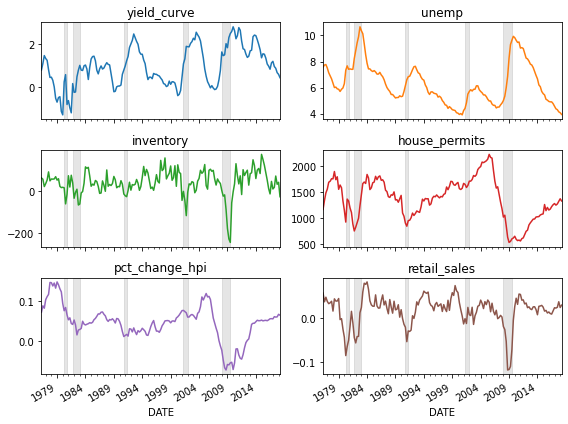

In [0]:
def add_recession_bands(ax):
    for s, e in zip(start_dates, end_dates):
        ax.axvspan(s, e, color="grey", alpha=0.2)

axs = indicators.plot(subplots=True, figsize=(8, 6), layout=(3, 2), legend=False)

for i, ax in enumerate(axs.flatten()):
    add_recession_bands(ax)
    ax.set_title(list(indicators)[i])

fig = axs[0, 0].get_figure()
fig.tight_layout();

In [0]:
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
import numpy as np

def make_train_data(indicators, rec, nlead=4):
    recc = rec.shift(nlead)
    return indicators.join(recc).dropna()

def fit_for_nlead(ind, rec, nlead, mod):
    df = make_train_data(ind, rec, nlead)
    print(df)
    X = df.drop(["recession"], axis=1).copy()
    y = df["recession"].copy()

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

    mod.fit(X_train, y_train)
    cmat = metrics.confusion_matrix(y_test, mod.predict(X_test))
    return cmat

mod = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    linear_model.LogisticRegression(solver="lbfgs")
)

cmats = dict()
for nlead in range(1, 11):
    cmats[nlead] = np.zeros((2, 2))
    print(f"starting for {nlead} leads")
    for rep in range(1):
        cmats[nlead] += fit_for_nlead(indicators, recession, nlead, mod)

    cmats[nlead] = cmats[nlead] / 200

for k, v in cmats.items():
    print(f"\n\nThe average confusion matrix for {k} lag(s) was:\n {v}")

starting for 1 leads
            yield_curve     unemp  ...  retail_sales  recession
DATE                               ...                         
1976-04-01     0.801364  7.566667  ...      0.056936        0.0
1976-07-01     1.099688  7.733333  ...      0.037207        0.0
1976-10-01     1.467377  7.766667  ...      0.047523        0.0
1977-01-01     1.332222  7.500000  ...      0.037939        0.0
1977-04-01     1.248254  7.133333  ...      0.032931        0.0
...                 ...       ...  ...           ...        ...
2017-04-01     0.963333  4.366667  ...      0.022948        0.0
2017-07-01     0.878730  4.300000  ...      0.024696        0.0
2017-10-01     0.677097  4.133333  ...      0.037249        0.0
2018-01-01     0.598033  4.066667  ...      0.024168        0.0
2018-04-01     0.443594  3.933333  ...      0.029594        0.0

[169 rows x 7 columns]
starting for 2 leads
            yield_curve     unemp  ...  retail_sales  recession
DATE                               ...